In [1]:
import sys
import os
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"

# Estimating PDF parameter values

From previous literature (Lima, 2021, https://doi.org/10.1016/j.jhydrol.2021.126095) it seems reasonable to assume a Bernoulli-Gamma distribution for daily snowfall. This has the form:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

The Bernoulli part gives the probability of rainfall (p) or no rainfall (1-p) on a given day at the site \(j\) for month \(k\) and the Gamma part gives the probability of an intensity of rainfall ($y_{jk}$) on that day given rainfall occurs. The gamma distribution has shape parameter $\alpha$ and scale parameter $\beta$. Note: it makes sense to include a Bernoulli term because of the discontinuity expected for the probability of no rainfall. The shape/scale parameters $\alpha$ and $\beta$ are estimated at every rainfall gauge and for each month of the year. 

Bayesian inference is used to estimate the parameters $p,\alpha,\beta$ for every rainfall gauge and month. 

\begin{equation}
    P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot \dfrac{P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} \propto P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

\begin{equation}
    P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}}) =
    (\prod_{jk} B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})) \cdot P(\boldsymbol{p,\alpha,\beta})
\end{equation}

## Single Site, Single Month Example

For a single site and single month we have:

$P(Y=y) = B(1,p)\cdot G(y|\alpha,\beta)$

$B(1,p)\cdot G(y|\alpha,\beta) = \ p \cdot \dfrac{\beta^\alpha y^{\alpha-1}e^{-\beta y}}{\Gamma(\alpha)} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

$Likelihood = P(\boldsymbol{Y}|p,\alpha,\beta)=L(\boldsymbol{Y}|p,\alpha,\beta)=\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)$

$Log Likehood = Log(L(\boldsymbol{Y}|p,\alpha,\beta))= LL(\boldsymbol{Y}|p,\alpha,\beta) =Log(\prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta))=\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$

In [2]:
data = np.load(
    "/data/notebooks/jupyterlab-biascorrlab/data/single_site_jan_precip.npy"
)  # This is 38 years of daily data for January

### Maximum Likelihood Estimation (MLE)

MLE assumes no correlation between parameters - e.g. $P(\alpha,\beta)=P(\alpha)\cdot P(\beta)$

MLE involves minimising the negative log likelihood (Note minimising and taking the log are done for compuational reasons): $-\sum_{i} Log(B(1,p)\cdot G(y_{i}|\alpha,\beta))$ where $y_i$ are our daily snowfall values.

In [3]:
# Defining the Negative Log Likelihood:

def negloglikelihoodsum(params, data):
    p, alpha, scale = (
        params[0],
        params[1],
        params[2],
    )  # Note scale is 1/Beta and is the parameter used in the scipy.stats.gamma function instead of beta

    likelihood_values = np.concatenate(
        (
            np.full(len(data[data == 0]), 1 - p),
            p * stats.gamma.pdf(data[data != 0], a=alpha, loc=0, scale=scale),
        )
    )

    return -np.sum(np.log(likelihood_values))

In [4]:
# Applying Nelder-Mead Minimiser

# Parameter Guesses [p,alpha,scale]
guess = [0.5, 0.1, 1.0]

# Parameter Bounds (I've found this is needed to improve stability of the minimiser)
bounds = [
    (0.001, 0.99),
    (0.00001, 100),
    (0.00001, 100),
]

# Minimising Function
results = minimize(
    negloglikelihoodsum,
    guess,
    args=data,
    method="Nelder-Mead",
    options={"disp": True},
    bounds=bounds,
)
print(results["x"])

Optimization terminated successfully.
         Current function value: 528.789202
         Iterations: 105
         Function evaluations: 184
[0.12554491 0.84049561 0.85811062]


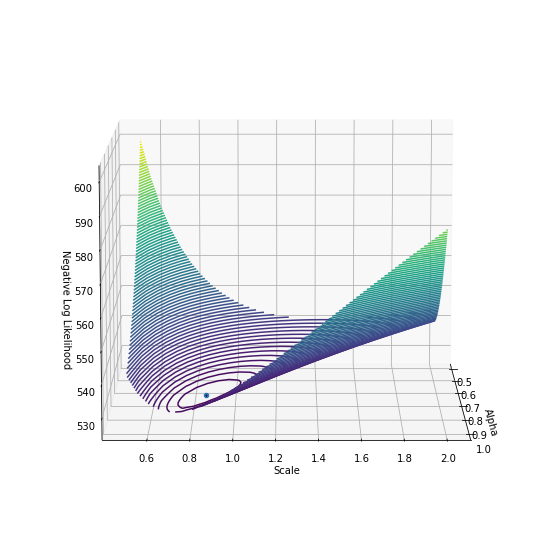

In [5]:
# Plotting the Negative LogLikelihood Space for Parameters Alpha and Beta with fixed P

n = 30
p = results["x"][0]
alphas = np.linspace(0.5, 1, n)
scales = np.linspace(0.5, 2, n)

alphas, scales = np.meshgrid(alphas, scales)
values = np.zeros((n, n))

for i in np.arange(0, n, 1):
    for j in np.arange(0, n, 1):
        values[i, j] = negloglikelihoodsum([p, alphas[i, j], scales[i, j]], data)

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.contour3D(alphas, scales, values, 100)  # , cmap='binary')

ax.set_xlabel("Alpha")
ax.set_ylabel("Scale")
ax.set_zlabel("Negative Log Likelihood")

ax.scatter(results["x"][1], results["x"][2], negloglikelihoodsum(results["x"], data))

ax.view_init(10, 0)

Probability of Snowfall (Data) = 0.87
Probability of Snowfall (Estimate) = 0.87


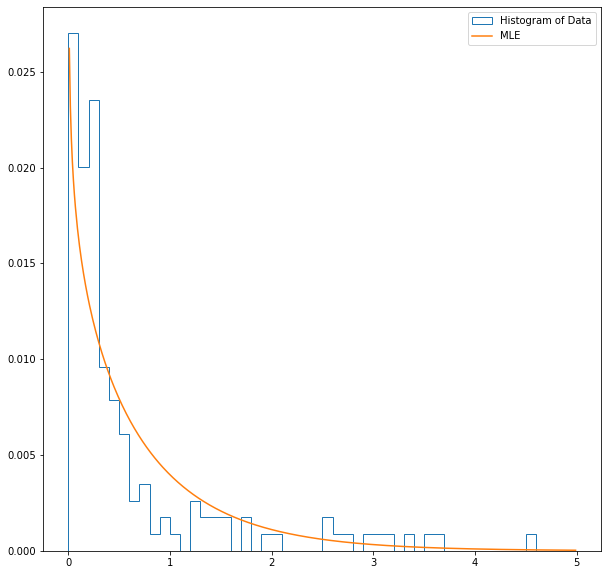

In [6]:
# Histogram of Data

bins = np.arange(0, 5, 0.1)
bin_width = bins[1] - bins[0]
bin_centers = bins + bin_width / 2

p = len(data[data != 0]) / len(data)
print(f"Probability of Snowfall (Data) = {round(1-p,2)}")
weights = np.full(len(data[data != 0]), p) / len(data[data != 0])
plt.hist(
    data[data != 0],
    bins=bins,
    histtype="step",
    stacked=True,
    fill=False,
    weights=weights,
    label="Histogram of Data",
)

# Plotting the Probability Density Function that Maximises the Likelihood
p, alpha, scale = results["x"]
xs = np.arange(0, 5, 0.01)
likelihoods = p * stats.gamma.pdf(xs, a=alpha, loc=0, scale=scale)
estimate = likelihoods * bin_width
print(f"Probability of Snowfall (Estimate) = {round(1-p,2)}")
plt.plot(xs, estimate, label="MLE")

plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 2954.174863
         Iterations: 125
         Function evaluations: 224
[ 0.71665185  0.57814979 11.42323652]
Probability of Snowfall (Data) = 0.28
Probability of Snowfall (Estimate) = 0.28


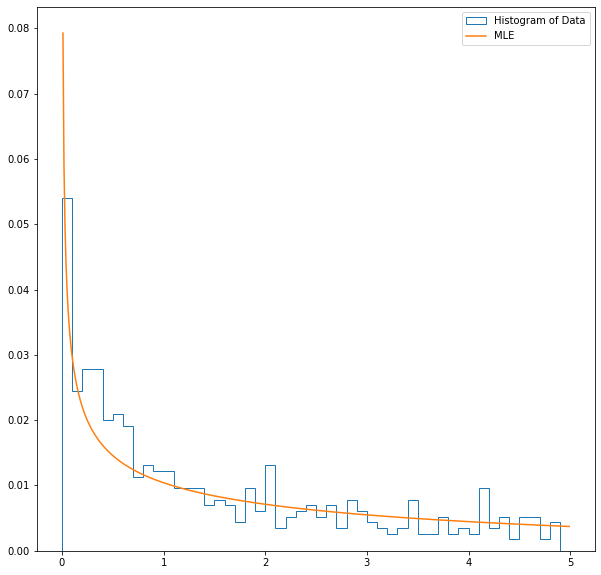

In [7]:
# Example for a site with a greater average snowfall.

%run MLE.py "/data/notebooks/jupyterlab-biascorrlab/data/single_site_jan_precip_high_snowfall.npy"